In [ ]:
!pip install sentence-transformers
!pip install langchain
!pip install chromadb
!pip install openai
!pip install google-generativeai
!pip install evaluate
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Create DB

In [ ]:
### REF - https://github.com/langchain-ai/langchain/issues/10990

from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores.chroma import Chroma
import os
import shutil
from sentence_transformers import SentenceTransformer
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import SentenceTransformerEmbeddings
import pathlib
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown
from google.colab import userdata
import time
from chromadb.utils import embedding_functions
from langchain.prompts import ChatPromptTemplate
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from evaluate import load
import evaluate

nltk.download('punkt')
nltk.download('stopwords')

def create_chromadb():
    global db
    try:
        if not db:
            raise NameError("db is not defined")
    except NameError:
        print("Database variable 'db' does not exist. Creating a new database.")
        link = "Web Scraped Data Full.txt"
        # Load the SentenceTransformer embeddings
        embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

        # Load the document and split it into chunks
        loader = TextLoader(link)
        documents = loader.load()

        # Split the documents into chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=500)
        chunks = text_splitter.split_documents(documents)

        db = Chroma.from_documents(documents=chunks, embedding=embedding_function, persist_directory="/chroma_db1")
        db.persist()

        print(f"Saved {len(chunks)} chunks")
    return db

def create_prompt_old(docs, query_text):
    PROMPT_TEMPLATE = """
    Answer the question based on the following context in one sentence:

    {context}

    ---

    Answer the question based on the above context: {question}
    """

    context_text = "\n\n---\n\n".join([doc.page_content for doc in docs[:2]])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)
    return(prompt)


def create_prompt(docs, query_text, previous_answers=None):
    PROMPT_TEMPLATE = """
    Answer the question based on the following context in one sentence:

    {context}

    ---

    Answer the question based on the above context: {question}
    """

    # Build context text by concatenating page content of documents
    context_texts = [doc.page_content for doc in docs[:2]]
    # Include previous answers in context if available
    if previous_answers:
        context_texts.extend(previous_answers)

    context_text = "\n\n---\n\n".join(context_texts)

    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)
    return prompt


def use_gemini(prompt):
    # Used to securely store your API key
    genai.configure(api_key='YOUR API ID HERE')

    model = genai.GenerativeModel('gemini-pro')

    response = model.generate_content(prompt)

    return(response)

def to_markdown(text):
    text = text.replace('•', '  *')
    return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

def cosine_similarity(sentence1, sentence2):
    # Preprocess the input sentences
    tokens1 = preprocess_text(sentence1)
    tokens2 = preprocess_text(sentence2)

    # Create vectors of word frequencies for each sentence
    word_freq1 = {word: tokens1.count(word) for word in set(tokens1)}
    word_freq2 = {word: tokens2.count(word) for word in set(tokens2)}

    # Get unique words from both sentences
    all_words = set(list(word_freq1.keys()) + list(word_freq2.keys()))

    # Create vectors for each sentence
    vector1 = np.array([word_freq1.get(word, 0) for word in all_words])
    vector2 = np.array([word_freq2.get(word, 0) for word in all_words])

    # Compute cosine similarity
    cosine_similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

    return cosine_similarity

def compute_rouge_score(pred_ans, ref):
    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions=[pred_ans], references=[ref])
    return(results)

def compute_bleu_score(reference, candidate):
    reference_tokens = word_tokenize(reference)
    candidate_tokens = word_tokenize(candidate)
    smooth = SmoothingFunction().method4
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smooth)
    return bleu_score

def get_all_metrics(query_text, docs, pred_ans):
    similarity_score = cosine_similarity(query_text, docs)
    print("Cosine Similarity:", similarity_score)

    blue_score = compute_bleu_score(docs, pred_ans)
    print("BLEU Score:", blue_score)

    rouge_score = compute_rouge_score(pred_ans, docs)
    print("Rouge Score:", rouge_score['rougeLsum'])

In [ ]:
def main():
    db = create_chromadb()

    start_time = time.time()

    query_text = "Does taking a non-medical leave allow me to remain in the U.S.?"

    docs = db.similarity_search(query_text)

    prompt = create_prompt(docs, query_text)
    res=use_gemini(prompt)

    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time:", execution_time, "seconds\n")
    print("QUERY:    ", query_text, "\n")
    print("ANSWER:   ", res.text, "\n")

    get_all_metrics(query_text, docs[0].page_content, res.text)

main()

Execution time: 1.7165672779083252 seconds

QUERY:     Does taking a non-medical leave allow me to remain in the U.S.? 

ANSWER:    No, taking a non-medical leave of absence requires students to spend the duration of their absence outside of the U.S. 

Cosine Similarity: 0.3674969681625189
BLEU Score: 0.0006201592462382884
Rouge Score: 0.20618556701030924


In [ ]:
def get_all_metrics1(query_text, actual_ans, pred_ans):
      similarity_score = cosine_similarity(actual_ans, pred_ans)
      blue_score = compute_bleu_score(actual_ans, pred_ans)
      rouge_score = compute_rouge_score(pred_ans, actual_ans)
      return [similarity_score, blue_score, rouge_score['rougeLsum']]

def paraphrase(question,
        num_beams=5,
        num_beam_groups=5,
        num_return_sequences=5,
        repetition_penalty=10.0,
        diversity_penalty=3.0,
        no_repeat_ngram_size=2,
        temperature=0.7,
        max_length=128
    ):
        device = "cuda"
        tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")
        model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)

        input_ids = tokenizer(
            f'paraphrase: {question}',
            return_tensors="pt", padding="longest",
            max_length=max_length,
            truncation=True,
        ).input_ids.to(device)

        outputs = model.generate(
            input_ids, temperature=temperature, repetition_penalty=repetition_penalty,
            num_return_sequences=num_return_sequences, no_repeat_ngram_size=no_repeat_ngram_size,
            num_beams=num_beams, num_beam_groups=num_beam_groups,
            max_length=max_length, diversity_penalty=diversity_penalty
        )

        res = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        return res


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM

def model_evaluation():
    my_file = open("RAG Questions.txt", "r")
    data = my_file.read()
    questions = data.replace('\n', '#').split("#")

    my_file = open("RAG Answers.txt", "r")
    data = my_file.read()
    answers = data.replace('\n', '#').split("#")

    paraphrase_questions = []
    for ques in questions:
        paraphrase_questions.append(paraphrase(ques))

    db = create_chromadb()

    avg_cosine = 0
    avg_bleu = 0
    lst_cosine = []
    lst_bleu = []
    lst_rouge = []
    for i in range(len(paraphrase_questions)):
        for j in range(len(paraphrase_questions[i])):
            query_text = paraphrase_questions[i][j]
            docs = db.similarity_search(query_text)
            prompt = create_prompt(docs, query_text)
            res = use_gemini(prompt)

            print("QUERY:    ", query_text)
            if len(res.parts) == 1:
                print("ANSWER:   ", res.parts[0].text)
                metric = get_all_metrics1(query_text, answers[i], res.text)
            else:
                for part in res.parts:
                    if part.name == 'response':
                        print("ANSWER:   ", part.text)
                        metric = get_all_metrics1(query_text, answers[i], res.text)

            print("Actual:   ", answers[i])

            lst_cosine.append(metric[0])
            lst_bleu.append(metric[1])
            lst_rouge.append(metric[2])
            print("Cosine Similarity:", metric[0])
            print("BLEU Score:", metric[1])
            print("Rouge Score:", metric[2], "\n")

    print("Average COSINE:  ", sum(lst_cosine)/len(lst_cosine))
    print("BLEU Score:  ", sum(lst_bleu)/len(lst_bleu))
    print("Rouge Score:  ", sum(lst_rouge)/len(lst_rouge))

    return lst_cosine, lst_bleu, lst_rouge

lst_cosine, lst_bleu, lst_rouge = model_evaluation()

QUERY:     Is it possible to apply for a program extension after the end of my I-20 program?
ANSWER:    No, it is not possible to apply for a program extension after the end of your I-20 program.
Actual:    No, after your program end date has passed, OGS is no longer able to extend your program. If you believe that you will need a program extension, please make sure that you apply with OGS well in advance. Not extending before your program end date will result in you losing valid F or J status and require corrective action at considerable expense to a student and potential loss of F-1 or J-1 benefits.
Actual:    No, after your program end date has passed, OGS is no longer able to extend your program. If you believe that you will need a program extension, please make sure that you apply with OGS well in advance. Not extending before your program end date will result in you losing valid F or J status and require corrective action at considerable expense to a student and potential loss of

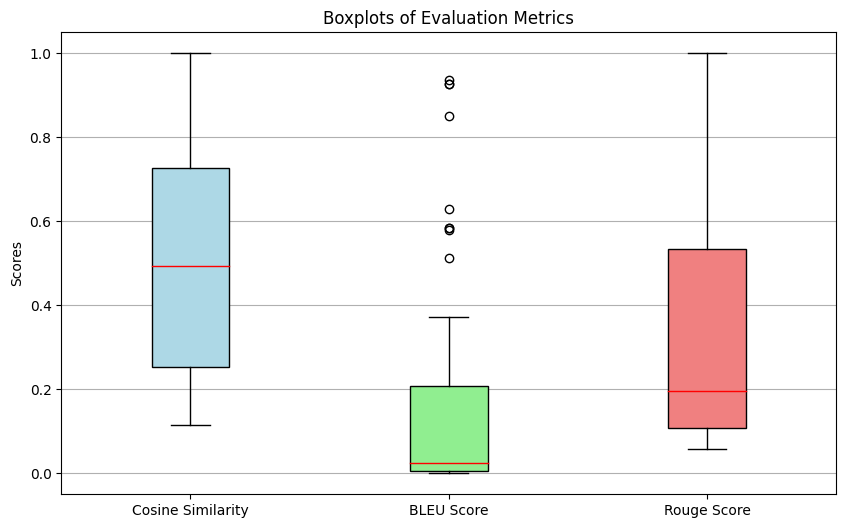

In [ ]:
import matplotlib.pyplot as plt

def plot_boxplots(lst_cosine, lst_bleu, lst_rouge):
    data_to_plot = [lst_cosine, lst_bleu, lst_rouge]
    labels = ['Cosine Similarity', 'BLEU Score', 'Rouge Score']

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Scores')

    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)

    for line in bp['medians']:
        line.set_color('red')  # Change median line color

    ax.yaxis.grid(True)

    plt.title('Boxplots of Evaluation Metrics')
    plt.show()

plot_boxplots(lst_cosine, lst_bleu, lst_rouge)


## Llama External Model Evaluation

In [ ]:
# Define the text with answers separated by a numbered heading.
text = """
Answer 0:
No, after your program end date has passed, OGS is no longer able to extend your program. If you believe that you will need a program extension, please make sure that you apply with OGS well in advance. Not extending before your program end date will result in you losing valid F or J status and require corrective action at considerable expense to a student and potential loss of F-1 or J-1 benefits.

Answer 1: Thank you for reaching out! I'm so sorry to hear that your application was rejected and returned to you. Firstly, please do not mail the application yet. It's essential to contact OGS and make an appointment with an OGS advisor to discuss your situation further. They will guide you on the next steps to take. It's important to note that if there is any chance your I-20 with Pre-Completion OPT recommendation will be more than 30 days old when it is received by the USCIS, it will result in a denial. Therefore, it's crucial to act quickly and follow the instructions provided by OGS to avoid any further complications. Again, I apologize for any inconvenience this may have caused, and I hope you get the support you need from OGS. Please let me know if there's anything else I can assist you with.

Answer 2: Yes, you can request for your application to be expedited by USCIS. Although USCIS generally does not accept expedite processing, you may try including a job offer letter and a cover letter explaining your job is expected to start on a certain day and send them along with the required documents for the Post-Completion OPT application. If you already have submitted the application to USCIS, you may call customer service and ask how to request the expedite processing. However, there is no guarantee that USCIS will honor your request. It is solely your responsibility to prepare the documents and submit the expedite request.

Answer 3: I apologize, but according to federal regulations, U.S. students taking a non-medical leave of absence must spend the duration of their absence outside of the U.S. I recommend consulting with OGS to discuss your options and ensure compliance with immigration regulations.

Answer 4: Hello! Thank you for reaching out to OGS with your question. If you need to return home during a required term, you should be aware that the maximum amount of time you can be outside of the U.S. is 5 months. After 5 months, you will need to obtain a new Initial I-20 document to return to the U.S. This will reset your eligibility requirements for CPT/OPT. Please refer to the OGS website for more information on the five-month rule and the process for obtaining a new Initial I-20. If you have any further questions or concerns, please don't hesitate to contact OGS.

Answer 5:
To start a new job, you typically need to have a Social Security Number (SSN). However, the SSA is only able to process your SSN application up to 30 days prior to your employment start date. Therefore, it is recommended that you apply for an SSN as soon as possible, but no earlier than 30 days before your employment start date. If you have not received your SSN by the time you start working, you may need to provide alternative forms of identification to your employer. Please consult with your employer and the Office of Global Services (OGS) for more information.

Answer 6: Yes, if you don’t need a full-time course load to complete your program, you can still be less than full-time in your final term even if you received a reduced course load prior to your final term. However, it is essential to confirm with your academic advisor that all graduation requirements have been met. Please refer to the Final Term page for more information.

Answer 7: Hello! Thank you for reaching out. The NU guard.me insurance policy provides coverage for students and their accompanying family members for a maximum of 2 years from the date of purchase. Please note that you will need to extend your policy before the expiry date to maintain coverage. If you have any further questions or concerns, please feel free to ask.

Answer 8:
You may be eligible to obtain a Northeastern DS-2019 as a transfer student; however, the U.S. institution from where you are transferring out has to process your transfer request before the completion date of your current program at that institution. The area of study for your transfer program at Northeastern must be the same as your area of study at your current institution. You will need to work with your current institution's international student office in order to follow the transfer out process and you will also need to work with OGS for the transfer in process.

Answer 9: Yes, you can still enroll in classes during the summer term even if it is not required for you. However, please note that you must maintain full-time enrollment and appropriate on-ground presence throughout the duration of the summer term to maintain your F-1 or J-1 status. If you have any questions or concerns about your summer enrollment, please consult directly with OGS.
"""

answers = [ans.strip() for ans in text.split('Answer ') if ans.strip()]

answer_list = []

for answer in answers:
    answer_number = int(answer[0])  # Extract the answer number
    answer_text = answer[2:].strip()  # Extract the answer text after the number
    answer_list.append(answer_text)
print(answer_list)

['No, after your program end date has passed, OGS is no longer able to extend your program. If you believe that you will need a program extension, please make sure that you apply with OGS well in advance. Not extending before your program end date will result in you losing valid F or J status and require corrective action at considerable expense to a student and potential loss of F-1 or J-1 benefits.', "Thank you for reaching out! I'm so sorry to hear that your application was rejected and returned to you. Firstly, please do not mail the application yet. It's essential to contact OGS and make an appointment with an OGS advisor to discuss your situation further. They will guide you on the next steps to take. It's important to note that if there is any chance your I-20 with Pre-Completion OPT recommendation will be more than 30 days old when it is received by the USCIS, it will result in a denial. Therefore, it's crucial to act quickly and follow the instructions provided by OGS to avoid

In [ ]:
my_file = open("RAG Answers.txt", "r")
data = my_file.read()
answers = data.replace('\n', '#').split("#")
i = 0

lst_cosine = []
lst_bleu = []
lst_rouge = []

for ans in answer_list:
    metric = get_all_metrics1('query_text', answers[i], ans)
    i+=1

    lst_cosine.append(metric[0])
    lst_bleu.append(metric[1])
    lst_rouge.append(metric[2])
    print("Cosine Similarity:", metric[0])
    print("BLEU Score:", metric[1])
    print("Rouge Score:", metric[2], "\n")

print("Average COSINE:  ", sum(lst_cosine)/len(lst_cosine))
print("BLEU Score:  ", sum(lst_bleu)/len(lst_bleu))
print("Rouge Score:  ", sum(lst_rouge)/len(lst_rouge))


Cosine Similarity: 0.9999999999999998
BLEU Score: 1.0
Rouge Score: 1.0 

Cosine Similarity: 0.6785975629240184
BLEU Score: 0.26727905953163644
Rouge Score: 0.4406779661016949 

Cosine Similarity: 0.8886794879900082
BLEU Score: 0.619858649040717
Rouge Score: 0.7836257309941521 

Cosine Similarity: 0.6708203932499369
BLEU Score: 0.36408223366015935
Rouge Score: 0.5915492957746479 

Cosine Similarity: 0.3956919133998724
BLEU Score: 0.022921470966183334
Rouge Score: 0.11353711790393013 

Cosine Similarity: 0.2796985743921602
BLEU Score: 0.01711445309052787
Rouge Score: 0.12000000000000001 

Cosine Similarity: 0.8703065493421591
BLEU Score: 0.538139739373518
Rouge Score: 0.7358490566037735 

Cosine Similarity: 0.27835560025568845
BLEU Score: 0.015162813087091215
Rouge Score: 0.2093023255813954 

Cosine Similarity: 0.9913793103448277
BLEU Score: 0.9657578041013585
Rouge Score: 1.0 

Cosine Similarity: 0.38624363966821407
BLEU Score: 0.03625164270250917
Rouge Score: 0.18749999999999997 

Aver

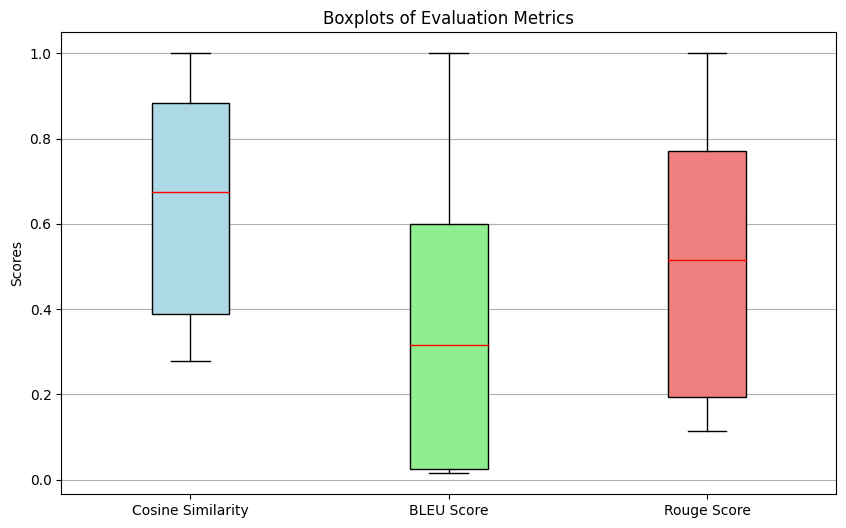

In [ ]:
import matplotlib.pyplot as plt

def plot_boxplots(lst_cosine, lst_bleu, lst_rouge):
    data_to_plot = [lst_cosine, lst_bleu, lst_rouge]
    labels = ['Cosine Similarity', 'BLEU Score', 'Rouge Score']

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Scores')

    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)

    for line in bp['medians']:
        line.set_color('red')  # Change median line color

    ax.yaxis.grid(True)

    plt.title('Boxplots of Evaluation Metrics')
    plt.show()

plot_boxplots(lst_cosine, lst_bleu, lst_rouge)



# Extra code GPT 2

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Instantiate the tokenizer and model for the desired LLM
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Generate a response using the model
input_text = prompt
input_ids = tokenizer.encode(input_text, return_tensors="pt")
output = model.generate(input_ids, max_length=500, num_return_sequences=1)
response_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the response
print("Response:", response_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Response: Human: 
    Answer the question based on the following context in one sentence:

    If my final term is in the summer can I take my last course online?

No, even if your last course is taking place during a summer vacation period you must still maintain an on-ground presence.

Do I have to tell the Office of Global Services that I'm dropping below full-time in my final semester?

No, the Office of Global Services does not have to be told if you are dropping below full-time. Just make sure that you are also maintaining on-ground presence.
What is a program extension?

International students who need additional time to complete their degree requirements must apply for an extension of their I-20 or DS-2019. In order to maintain their status, they must apply for this extension before their current I-20 or DS-2019 program end date. Students receive an I-20 or DS-2019 based on Northeastern University’s program objectives, which account for any college approved experiential learnin

In [ ]:
from transformers import pipeline

# Load the model and tokenizer
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad", tokenizer="distilbert-base-cased")

# Generate an answer
result = qa_pipeline(question=query_text, context=docs)

# Extract and return the answer
print(result["answer"])